<a href="https://colab.research.google.com/github/nicolas1805961/GE_reinforcement_learning/blob/master/data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import math
import random
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
patches1 = np.load("/content/drive/My Drive/patches1.npy", allow_pickle=True)
patches2 = np.load("/content/drive/My Drive/patches2.npy", allow_pickle=True)
transforms = np.load("/content/drive/My Drive/transformations.npy", allow_pickle=True)
big_images = np.load("/content/drive/My Drive/big_images.npy", allow_pickle=True)
positions = np.load("/content/drive/My Drive/patches2_pos.npy", allow_pickle=True)
transforms = transforms[..., :-1].astype(np.int16)
patches1 = patches1.astype(np.float32)
patches2 = patches2.astype(np.float32)
print(patches1.shape)
print(patches2.shape)
print(transforms.shape)
print(big_images.shape)
print(positions.shape)

(180, 150, 150)
(180, 50, 150, 150)
(180, 50, 3)
(180, 512, 512)
(180, 50, 2)


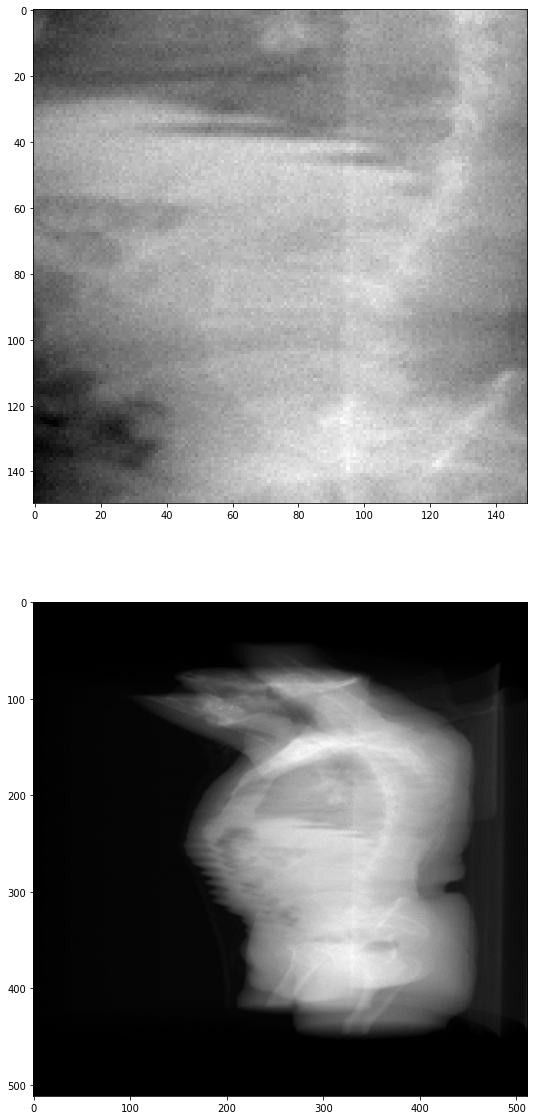

In [5]:
#list_of_patches_images = []
#right_images_index = []
#for i in range(patches.shape[0]):
#  list_of_patches_one_image = []
#  list_of_transforms_one_image = []
#  for j in range(50):
#    if patches[i, j].shape == (50, 50):
#      list_of_patches_one_image.append(patches[i, j])
#  patches_one_image = np.stack(list_of_patches_one_image)
#  if patches_one_image.shape[0] == 50:
#    list_of_patches_images.append(patches_one_image)
#    right_images_index.append(i)
#data = np.stack(list_of_patches_images)
#patches1 = images[right_images_index]
#big_images = big_images[right_images_index]
#transforms = transforms[right_images_index]
#print(data.shape)
#print(patches1.shape)
#print(big_images.shape)

fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].imshow(patches1[1], cmap='gray')
ax[1].imshow(big_images[1], cmap='gray')

In [6]:
print(patches1[1])

[[107. 110. 109. ... 145. 142. 138.]
 [106. 110. 108. ... 144. 143. 139.]
 [112. 110. 109. ... 143. 141. 138.]
 ...
 [ 93.  94.  96. ... 136. 141. 134.]
 [ 92.  91.  94. ... 135. 137. 134.]
 [ 89.  92.  95. ... 133. 137. 134.]]


[-17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.
  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.
  11.  12.  13.]


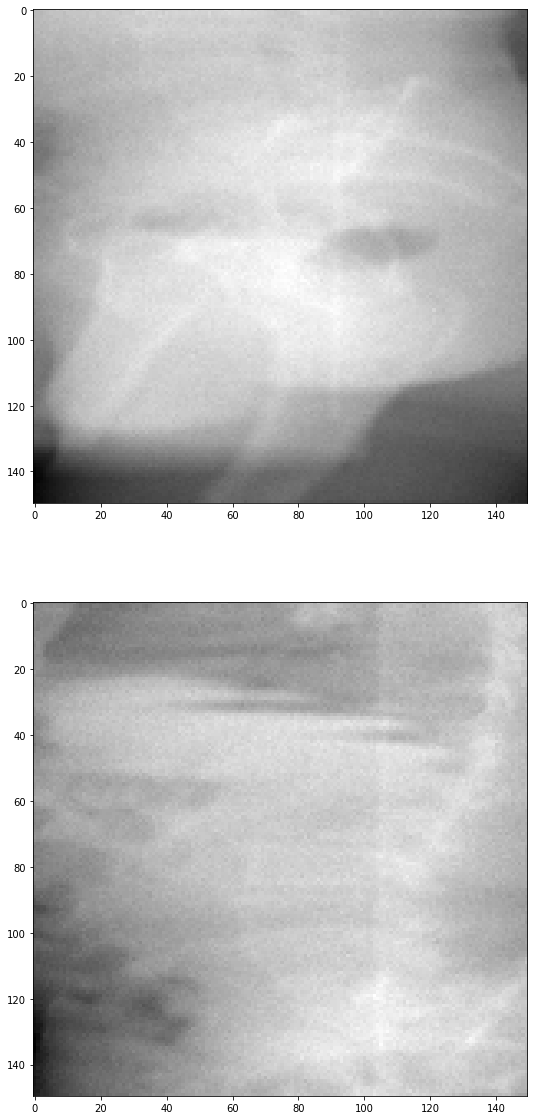

In [7]:
from skimage.transform import resize, rescale

def translate_image(big_image, position, translation):
  return big_image[position[0, 0] + translation[1]:position[0, 0] + translation[1] + 150, position[0, 1] + translation[0]:position[0, 1] + translation[0] + 150]
  #return resize(base_image, (50, 50), anti_aliasing=False)

new = translate_image(big_images[2], positions[2, 1].reshape(1, 2), np.array([0, 1])).astype(np.float32)
prev = translate_image(big_images[2], positions[2, 1].reshape(1, 2), np.array([0, 0])).astype(np.float32)
print(np.unique(new - prev))
fig, ax = plt.subplots(2, 1, figsize=(10, 20))
ax[0].imshow(new, cmap='gray')
ax[1].imshow(patches2[1, 0, ...], cmap='gray')

In [8]:
X_list = []
Y_list = []
positions_list = []
first_images_list = []
second_images_list = []
big_images_list = []
for i in range(patches1.shape[0]):
  patch1 = patches1[i].copy().reshape(1, 150, 150)
  big_image = big_images[i].copy().reshape(1, 512, 512)
  batch_patch1 = np.repeat(patch1, 50, axis=0)
  batch_big_image = np.repeat(big_image, 50, axis=0)
  batch = (batch_patch1 - patches2[i]).astype(np.float32)
  batch = np.expand_dims(batch, axis=(1))
  batch /= 255
  big_images_list.append(batch_big_image)
  first_images_list.append(batch_patch1)
  second_images_list.append(patches2[i])
  X_list.append(batch)
  Y_list.append(transforms[i])
  positions_list.append(positions[i])
X = np.concatenate(X_list)
Y = np.concatenate(Y_list)
positions = np.concatenate(positions_list)
big_images = np.concatenate(big_images_list)
first_images = np.concatenate(first_images_list)
second_images = np.concatenate(second_images_list)
del patches1, patches2, transforms
print(X.shape)
print(Y.shape)
print(first_images.shape)
print(second_images.shape)
print(big_images.shape)
print(positions.shape)

(9000, 1, 150, 150)
(9000, 3)
(9000, 150, 150)
(9000, 150, 150)
(9000, 512, 512)
(9000, 2)


In [9]:
print(np.unique(X))

[-0.3764706  -0.37254903 -0.36862746 -0.3647059  -0.36078432 -0.35686275
 -0.3529412  -0.34901962 -0.34509805 -0.34117648 -0.3372549  -0.33333334
 -0.32941177 -0.3254902  -0.32156864 -0.31764707 -0.3137255  -0.30980393
 -0.30588236 -0.3019608  -0.29803923 -0.29411766 -0.2901961  -0.28627452
 -0.28235295 -0.2784314  -0.27450982 -0.27058825 -0.26666668 -0.2627451
 -0.25882354 -0.25490198 -0.2509804  -0.24705882 -0.24313726 -0.23921569
 -0.23529412 -0.23137255 -0.22745098 -0.22352941 -0.21960784 -0.21568628
 -0.21176471 -0.20784314 -0.20392157 -0.2        -0.19607843 -0.19215687
 -0.1882353  -0.18431373 -0.18039216 -0.1764706  -0.17254902 -0.16862746
 -0.16470589 -0.16078432 -0.15686275 -0.15294118 -0.14901961 -0.14509805
 -0.14117648 -0.13725491 -0.13333334 -0.12941177 -0.1254902  -0.12156863
 -0.11764706 -0.11372549 -0.10980392 -0.10588235 -0.10196079 -0.09803922
 -0.09411765 -0.09019608 -0.08627451 -0.08235294 -0.07843138 -0.07450981
 -0.07058824 -0.06666667 -0.0627451  -0.05882353 -0.

In [10]:
from math import cos, sin

class Q_value():
    def __init__(self, gamma, epsilon, R, number_of_outputs, rotation_step, translation_step):
        self.Tg = None
        self.gamma = gamma
        self.epsilon = epsilon
        self.R = R
        self.number_of_outputs = number_of_outputs
        self.rotation_step = rotation_step
        self.translation_step = translation_step

    def get_matrix_from_tensor(self, Tt):
        if self.number_of_outputs == 12:
            A = torch.tensor([[1, 0, 0, Tt[0]],
                            [0, cos(Tt[3]), -sin(Tt[3]), Tt[1]],
                            [0, sin(Tt[3]), cos(Tt[3]), Tt[2]],
                            [0, 0, 0, 1]])

            B = torch.tensor([[cos(Tt[4]), 0, sin(Tt[4]), 0],
                            [0, 0, 0, 0],
                            [-sin(Tt[4]), 0, cos(Tt[4]), 0],
                            [0, 0, 0, 1]])

            C = torch.tensor([[cos(Tt[5]), -sin(Tt[5]), 0, 0],
                            [sin(Tt[5]), cos(Tt[5]), 0, 0],
                            [0, 0, 1, 0],
                            [0, 0, 0, 1]])

            D = torch.matmul(A, B)
            return torch.matmul(D, C)
        
        elif self.number_of_outputs == 6:

            A = torch.tensor([[cos(Tt[0]), sin(Tt[0]), Tt[1]],
                            [-sin(Tt[0]), cos(Tt[0]), Tt[2]],
                            [0, 0, 1]])
            
            return A
            

    def get_optimal_action(self, Tt):
        at = torch.cat((torch.eye(self.number_of_outputs // 2), torch.eye(self.number_of_outputs // 2) * -1))
        at = at
        at_o_Tt = at + Tt.view((1, 3))
        norms = [self.get_distance(at_o_Tt[i, :]) for i in range(self.number_of_outputs)]
        return np.argmin(np.asarray(norms))
    
    def get_distance(self, x):
        if self.number_of_outputs == 4 or self.number_of_outputs == 6:
            inversed = x * -1
            composed = self.Tg + inversed
        else:
            matrice = self.get_matrix_from_tensor(x)
            inversed = torch.inverse(matrice)
            Tg_matrix = self.get_matrix_from_tensor(self.Tg)
            composed = torch.matmul(Tg_matrix, inversed)
        composed = composed.float()
        norm = torch.norm(composed).item()
        return norm
    
    def set_Tg(self, Tg):
        self.Tg = Tg

    def take_action(self, action, Tt):
        current_Tt = Tt.clone()
        if action == 0:
            current_Tt[action] += self.rotation_step
        elif action == 3:
            current_Tt[0] -= self.rotation_step
        elif action < self.number_of_outputs // 2:
          current_Tt[action] += self.translation_step
        else:
          current_Tt[action - (self.number_of_outputs // 2)] -= self.translation_step
        return current_Tt
    
    def get_reward(self, Tt, Tt_next):
        return self.get_distance(Tt) - self.get_distance(Tt_next)

    def get_q_value(self, Tt, action):
        Tt_next = self.take_action(action, Tt)
        reward = self.get_reward(Tt, Tt_next)
        if self.get_distance(Tt_next) < self.epsilon:
            return reward + self.R
        optimal_action_next = self.get_optimal_action(Tt_next)
        return reward + self.gamma * self.get_q_value(Tt_next, optimal_action_next)
    
    def get_q(self, number_of_images, Y_train, Tt):
      q_values = torch.zeros((number_of_images, 6)).to(device)
      for i in range(number_of_images):
          print('\r{}'.format(i), end='')
          self.set_Tg(Y_train[i])
          row = []
          for t in range(6):
              row.append(self.get_q_value(Tt, t))
          q_values[i, :] = torch.tensor(row).reshape((1, -1))
      return q_values

In [11]:
class Dataset_train(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Q, transform):
        'Initialization'
        self.X = X
        self.Q = Q
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Q = self.Q[index]

        return X, Q

In [12]:
#class Dataset_test(torch.utils.data.Dataset):
#  'Characterizes a dataset for PyTorch'
#  def __init__(self, X, Y, first_images, root_image, second_translation, transform):
#        'Initialization'
#        self.X = X
#        self.Y = Y
#        self.first_images = first_images
#        #self.second_images = second_images
#        self.root = root_image
#        self.second_translation = second_translation
#        self.transform = transform
#
#  def __len__(self):
#        'Denotes the total number of samples'
#        return self.X.shape[0]
#
#  def __getitem__(self, index):
#        'Generates one sample of data'
#        # Select sample
#        X = self.X[index]
#        #X = self.transform(X)
#
#        # Load data and get label
#        Y = self.Y[index]
#        
#        one = self.first_images[index]
#        #two = self.second_images[index]
#        
#        root_image = self.root[index]
#        second_translation = self.second_translation[index]
#
#        return X, Y, one, root_image, second_translation

In [13]:
class Dataset_test(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y, first_images, second_images, positions, big_images, transform):
        'Initialization'
        self.X = X
        self.Y = Y
        self.first_images = first_images
        self.second_images = second_images
        self.positions = positions
        self.big_images = big_images
        self.transform = transform

  def __len__(self):
        'Denotes the total number of samples'
        return self.X.shape[0]

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        #X = self.transform(X)

        # Load data and get label
        Y = self.Y[index]
        
        one = self.first_images[index]
        two = self.second_images[index]

        position = self.positions[index]
        big_image = self.big_images[index]

        return X, Y, one, two, position, big_image

In [14]:
from sklearn.model_selection import train_test_split

transform = T.Compose([T.Normalize((0.5), (0.5))])

all_indices = list(range(X.shape[0]))
test_size_percent = 20 / X.shape[0]
test_size = test_size_percent * len(all_indices)
train_indices, test_indices = train_test_split(all_indices, test_size=test_size_percent, random_state=42)
del all_indices
X_train = torch.from_numpy(X[train_indices, ...])
X_test = torch.from_numpy(X[test_indices, ...])
del X
Y_train = Y[train_indices, ...]
Y_test = Y[test_indices, ...]
del Y
dataset_test = Dataset_test(X_test, Y_test, first_images[test_indices], second_images[test_indices], positions[test_indices], big_images[test_indices], transform)
del train_indices, first_images, X_test, Y_test, second_images, test_indices, positions, big_images
testing_generator = torch.utils.data.DataLoader(dataset_test, 1, shuffle=True)

In [15]:
print(Y_train)

[[  0  -2  -6]
 [  0   8  -9]
 [  0   5   2]
 ...
 [  0   0 -10]
 [  0  10  -6]
 [  0  -4   0]]


In [16]:
q_value_1 = Q_value(0.9, 0.5, 10, 6, 10, 1)
Tt = torch.zeros(3)
q_values = q_value_1.get_q(X_train.shape[0], torch.from_numpy(Y_train), Tt)

8979

In [17]:
for i in range(10):
    print(Y_train[i])
    print(q_values[i])

[ 0 -2 -6]
tensor([7.0510, 7.6558, 7.5062, 7.0510, 9.1925, 9.3849], device='cuda:0')
[ 0  8 -9]
tensor([5.9121, 7.7359, 6.1967, 5.9121, 6.2045, 7.7447], device='cuda:0')
[0 5 2]
tensor([7.0037, 9.3839, 9.2476, 7.0037, 7.5070, 7.6096], device='cuda:0')
[ 0  4 -7]
tensor([6.4721, 8.4988, 6.8622, 6.4721, 6.9305, 8.5808], device='cuda:0')
[  0 -10   6]
tensor([6.2047, 6.4879, 8.0280, 6.2047, 8.1169, 6.5661], device='cuda:0')
[0 7 6]
tensor([6.1224, 8.0995, 8.0877, 6.1224, 6.4825, 6.4926], device='cuda:0')
[ 0 -5 -2]
tensor([7.0037, 7.5070, 7.6096, 7.0037, 9.3839, 9.2476], device='cuda:0')
[0 8 3]
tensor([6.8133, 8.9805, 8.7829, 6.8133, 7.1799, 7.3440], device='cuda:0')
[0 7 9]
tensor([6.0100, 7.8568, 7.8845, 6.0100, 6.3303, 6.3059], device='cuda:0')
[ 0 -1 -5]
tensor([7.4527, 8.1594, 7.9669, 7.4527, 9.6895, 9.9572], device='cuda:0')


In [18]:
dataset_train_1 = Dataset_train(X_train, q_values, transform)
training_generator_1 = torch.utils.data.DataLoader(dataset_train_1, 32, shuffle=True)
del q_values, dataset_train_1, X_train, Y_train

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, d, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.maxpool1 = nn.MaxPool2d(2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 32, kernel_size=3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(w, f=3, p=0, s=1):
            return ((w - f + 2*p) // s) + 1
        
        def maxpool_size_out(w):
            return w // 2
        
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(maxpool_size_out(conv2d_size_out(w)))))))
        linear_input_size = convw * convw * 128
        
        self.head1 = nn.Linear(linear_input_size, 512)
        self.head2 = nn.Linear(512, 512)
        self.head3 = nn.Linear(512, 64)
        self.head4 = nn.Linear(64, outputs)
        
        self.linear_input_size = linear_input_size

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.maxpool1(self.conv1(x))))
        x = F.relu(self.bn2(self.maxpool2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(-1, self.linear_input_size)
        x = F.relu(self.head1(x))
        x = F.relu(self.head2(x))
        x = F.relu(self.head3(x))
        return self.head4(x)

#for x, y in training_generator:
#    print(x.size())
 #   net = DQN(1, x.shape[2], x.shape[3], 4).float()
#    out = net(x.float())
#    print(out.max(1)[1])
#    print(torch.argmax(out, dim=1))
#    break

In [20]:
from itertools import count

policy_net_1 = DQN(1, 150, 150, 6).to(device)
correct = 0
optimizer = optim.Adam(policy_net_1.parameters())
criterion = nn.MSELoss().to(device)
running_loss = 0.0
number_of_epoch = 200

for i_episode in range(number_of_epoch):
    for index, batch in enumerate(training_generator_1):
        x = batch[0].to(device)
        q = batch[1].to(device)

        optimizer.zero_grad()
        out = policy_net_1(x.float()).to(device)

        if torch.argmax(out) == torch.argmax(q):
          correct += 1
        
        #loss = torch.norm(out - q, dim=1).sum()
        loss = criterion(out, q)

        loss.backward()
        #for param in policy_net.parameters():
         #   param.grad.data.clamp_(-1, 1)
        optimizer.step()
        
        running_loss += loss.item()
    accuracy = correct / (index + 1)
    correct = 0
    # print statistics
    print("Epoch: {} Loss: {} Accuracy: {}".format((i_episode + 1), running_loss / (i_episode + 1), accuracy))


Epoch: 1 Loss: 616.3962175250053 Accuracy: 0.05693950177935943
Epoch: 2 Loss: 417.2744843363762 Accuracy: 0.099644128113879
Epoch: 3 Loss: 330.567528411746 Accuracy: 0.1423487544483986
Epoch: 4 Loss: 283.24497367814183 Accuracy: 0.17437722419928825
Epoch: 5 Loss: 248.54764248877763 Accuracy: 0.1601423487544484
Epoch: 6 Loss: 222.2840915272633 Accuracy: 0.22419928825622776
Epoch: 7 Loss: 203.25167806765862 Accuracy: 0.20640569395017794
Epoch: 8 Loss: 187.3062635231763 Accuracy: 0.2491103202846975
Epoch: 9 Loss: 174.51641491386624 Accuracy: 0.2669039145907473
Epoch: 10 Loss: 164.71294183954598 Accuracy: 0.2704626334519573
Epoch: 11 Loss: 155.1879767226902 Accuracy: 0.3238434163701068
Epoch: 12 Loss: 147.43606948417923 Accuracy: 0.3487544483985765
Epoch: 13 Loss: 139.8707676991247 Accuracy: 0.37722419928825623
Epoch: 14 Loss: 133.85181609275085 Accuracy: 0.35587188612099646
Epoch: 15 Loss: 128.37804911161462 Accuracy: 0.3914590747330961
Epoch: 16 Loss: 123.13668142049573 Accuracy: 0.46975

In [21]:
from skimage.measure import label, regionprops, approximate_polygon, find_contours

def get_perimeter(image):
    img = image.copy()
    binary = (img > 20)
    perimeter = 0
    contour = sorted(find_contours(binary, 0), key=lambda x: x.shape[0])[-1]
    perimeter = approximate_polygon(contour, tolerance=0)
    return perimeter

In [22]:
from torchvision.transforms.functional import normalize, to_pil_image, to_tensor, affine

policy_nets = [policy_net_1]
q_values = [q_value_1]
correct = 0
total = 20
number_of_steps = 200
list_of_examples = []
#perimeters = []
with torch.no_grad():
    for data in testing_generator:
        list_of_frames = []
        print('***************************')
        x = data[0].to(device)
        y = data[1]
        first_image = data[2]
        second_image = to_pil_image(data[3].int())
        position = data[4]
        big_image = data[5].reshape(512, 512)
        Tt = torch.zeros((number_of_steps, 3), dtype=torch.int16)
        print(y)
        print('/*/*/*/*/*/*/*/*/*/*/*/*/*/*')
        #perimeters.append(get_perimeter(first_image[0, ...].numpy()))
        j = 0
        while j < number_of_steps - 1:
            out = policy_net_1(x.float())
            action = torch.argmax(out, dim=1)
            Tt[j + 1, :] = q_value_1.take_action(action, Tt[j, :])
            translation = np.array([Tt[j + 1, 1].item(), Tt[j + 1, 2].item()])
            if np.amax(position.numpy() + translation[::-1]) + 150 == 511 or np.amin(position.numpy() + translation[::-1]) == 0:
              break
            current_image = translate_image(big_image, position, translation)
            #current_image = to_tensor(affine(second_image, angle=Tt[j + 1, 0].item(), translate=translation, scale=1, shear=0))
            list_of_frames.append(current_image.numpy().reshape((150, 150)))
            diff = first_image - current_image
            diff /= 255
            x = diff.unsqueeze(0).to(device)
            if torch.unique(Tt[:j + 2], dim=0).size(0) == torch.unique(Tt[:j + 1], dim=0).size(0):
              if torch.dist(Tt[j + 1, :].float(), y).item() <= 1:
                  correct += 1
              if torch.sum(Tt[j + 1]) > torch.sum(Tt[j]):
                j += 1
              break
            j += 1
        stack_of_frames = np.stack(list_of_frames)
        #stack_of_frames = np.pad(stack_of_frames, ((0, number_of_steps - stack_of_frames.shape[0]), (0, 0), (0, 0)))
        list_of_examples.append(stack_of_frames)
        mask = Tt.eq(torch.zeros((number_of_steps, 3))).all(dim=1)
        Tt = Tt[~mask]
        print(Tt)
    print('accuracy {}%'.format(100 * correct / total))

***************************
tensor([[0, 8, 5]], dtype=torch.int16)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
tensor([[0, 1, 0],
        [0, 2, 0],
        [0, 3, 0],
        [0, 4, 0]], dtype=torch.int16)
***************************
tensor([[  0, -10,   8]], dtype=torch.int16)
/*/*/*/*/*/*/*/*/*/*/*/*/*/*
tensor([[  0,  -1,   0],
        [  0,  -2,   0],
        [  0,  -3,   0],
        [  0,  -4,   0],
        [  0,  -5,   0],
        [  0,  -6,   0],
        [  0,  -7,   0],
        [  0,  -8,   0],
        [  0,  -9,   0],
        [  0, -10,   0],
        [  0, -11,   0],
        [  0, -12,   0],
        [  0, -13,   0],
        [  0, -14,   0],
        [  0, -15,   0],
        [  0, -16,   0],
        [  0, -17,   0],
        [  0, -18,   0],
        [  0, -18,  -1],
        [  0, -18,  -2],
        [  0, -18,  -3],
        [  0, -18,  -4],
        [  0, -18,  -5],
        [  0, -18,  -6],
        [  0, -18,  -7],
        [  0, -18,  -8],
        [  0, -18,  -9],
        [  0, -18, -10],
      

In [23]:
print(list_of_examples[0].shape)

(3, 150, 150)


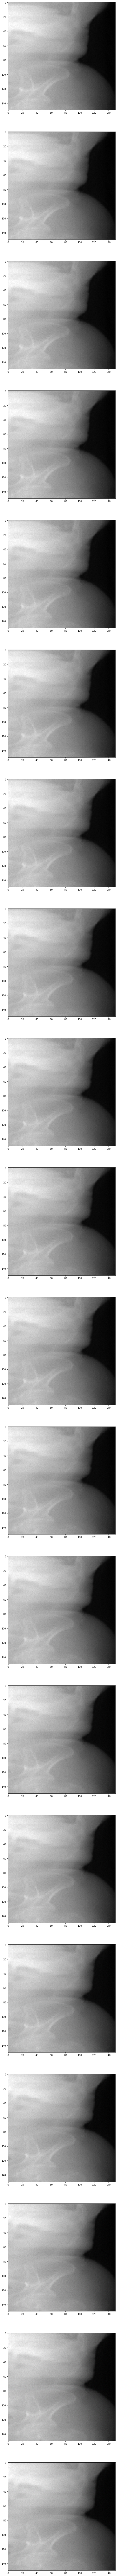

In [24]:
index = np.argmax([x.shape[0] for x in list_of_examples])
frames = list_of_examples[index][:20, ...]
#perimeter = perimeters[index]
fig, ax = plt.subplots(frames.shape[0], 1, figsize=(16, 10*frames.shape[0]))
for i in range(frames.shape[0]):
    #ax[i].plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
    ax[i].imshow(frames[i], cmap='gray')

In [25]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.backends.backend_pdf

pdf = matplotlib.backends.backend_pdf.PdfPages("/content/output.pdf")
library = np.concatenate(list_of_examples)
#perimeters_thresh = [x.shape[0] for x in list_of_examples]
#cum_thresh = np.cumsum(perimeters_thresh)
j = 0
i = 0
while i < library.shape[0]:
  #if i >= cum_thresh[j]:
  #  j += 1
  #perimeter = perimeters[j]
  fig, ax = plt.subplots(1, 1, figsize=(8, 8))
  #ax.plot(perimeter[:, 1], perimeter[:, 0], '-r', linewidth=1)
  ax.imshow(library[i], cmap='gray')
  i += 1
  pdf.savefig(fig, bbox_inches='tight')
  plt.close(fig)
pdf.close()

#library = np.stack(list_of_examples)
#for i in range(10):
#    interact(display, img=fixed(library[i, ...]), perimeters=fixed(perimeters[i]), slice_number=widgets.IntSlider(min=0, max=library[i, ...].shape[0] - 1, step=1, value=0))